# Boosting RAG: Picking the Best Embedding & Reranker models

When building a Retrieval Augmented Generation (RAG) pipeline, one key component is the Retriever. We have a variety of embedding models to choose from, including OpenAI, CohereAI, and open-source sentence transformers. Additionally, there are several rerankers available from CohereAI and sentence transformers.

But with all these options, how do we determine the best mix for top-notch retrieval performance? How do we know which embedding model fits our data best? Or which reranker boosts our results the most?

In this tutorial Notebook, we'll use the `Retrieval Evaluation` module from LlamaIndex to swiftly determine the best combination of embedding and reranker models. Let's dive in!

Let’s first start with understanding the metrics available in `Retrieval Evaluation`

**Understanding Metrics in Retrieval Evaluation**:

To gauge the efficacy of our retrieval system, we primarily relied on two widely-accepted metrics: **Hit Rate** and **Mean Reciprocal Rank (MRR)**. Let's delve into these metrics to understand their significance and how they operate.

- **Hit Rate**:
    
    Hit rate calculates the fraction of queries where the correct answer is found within the top-k retrieved documents. In simpler terms, it's about how often our system gets it right within the top few guesses.
    
- **Mean Reciprocal Rank (MRR)**:
    
    For each query, MRR evaluates the system's accuracy by looking at the rank of the highest-placed relevant document. Specifically, it's the average of the reciprocals of these ranks across all the queries. So, if the first relevant document is the top result, the reciprocal rank is 1; if it's second, the reciprocal rank is 1/2, and so on.

In [ ]:
!pip install llama-index sentence-transformers cohere anthropic voyageai protobuf pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.1/846.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.8/801.8 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.5 MB

## Setting Up the Environment

In [ ]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.node_parser import SimpleNodeParser

# LLM
from llama_index.llms import Anthropic

# Embeddings
from llama_index.embeddings import OpenAIEmbedding, HuggingFaceEmbedding, CohereEmbedding
from langchain.embeddings import VoyageEmbeddings, GooglePalmEmbeddings

# Retrievers
from llama_index.retrievers import (
    BaseRetriever,
    VectorIndexRetriever,
)

# Rerankers
from llama_index.indices.query.schema import QueryBundle, QueryType
from llama_index.schema import NodeWithScore
from llama_index.indices.postprocessor.cohere_rerank import CohereRerank
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.finetuning.embeddings.common import EmbeddingQAFinetuneDataset

# Evaluator
from llama_index.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)
from llama_index.evaluation import RetrieverEvaluator


from typing import List
import pandas as pd
import openai
import voyageai

import nest_asyncio

nest_asyncio.apply()

## Settingup API Keys

In [ ]:
openai_api_key = 'YOUR OPENAI API KEY'
cohere_api_key = 'YOUR COHEREAI API KEY'
anthropic_api_key = 'YOUR ANTHROPIC API KEY'
voyage_api_key = 'YOUR VOYAGE API KEY'
google_api_key = 'YOUR GOOGLE PALM API KEY'
openai.api_key = openai_api_key

## Download Data

We will use Llama2 paper for this experiment. Let's download the paper.

In [ ]:
!wget --user-agent "Mozilla" "https://arxiv.org/pdf/2307.09288.pdf" -O "llama2.pdf"

## Loading the Data

Let’s load the data. We will use Pages from start to 36 for the experiment which excludes table of contents, references and appendix.

This data was then parsed by converted to nodes, which represent chunks of data we'd like to retrieve. We did use chunk_size as 512.

In [ ]:
documents = SimpleDirectoryReader(input_files=['llama2.pdf']).load_data()

In [ ]:
node_parser = SimpleNodeParser.from_defaults(chunk_size=512)
nodes = node_parser.get_nodes_from_documents(documents[:37])

## Generating Question-Context Pairs

For evaluation purposes, we created a dataset of question-context pairs. This dataset can be seen as a set of questions and their corresponding context from our data. To remove bias for evaluation of embedding(OpenAI/ CohereAI) and Reranker (CohereAI), we use Anthropic LLM to generate Question-Context Pairs.

Let's initialize prompt template to generate question-context pairs.

In [ ]:
# Prompt to generate questions
qa_generate_prompt_tmpl = """\
Context information is below.

---------------------
{context_str}
---------------------

Given the context information and not prior knowledge.
generate only questions based on the below query.

You are a Professor. Your task is to setup \
{num_questions_per_chunk} questions for an upcoming \
quiz/examination. The questions should be diverse in nature \
across the document. The questions should not contain options, not start with Q1/ Q2. \
Restrict the questions to the context information provided.\
"""

In [ ]:
llm = Anthropic(api_key=anthropic_api_key, temperature=0)
qa_dataset = generate_question_context_pairs(
    nodes, llm=llm, num_questions_per_chunk=2, qa_generate_prompt_tmpl=qa_generate_prompt_tmpl
)

Function to filter out sentences such as `Here are 2 questions based on provided context`

In [ ]:
# function to clean the dataset
def filter_qa_dataset(qa_dataset):
    """
    Filters out queries from the qa_dataset that contain certain phrases and the corresponding
    entries in the relevant_docs, and creates a new EmbeddingQAFinetuneDataset object with
    the filtered data.

    :param qa_dataset: An object that has 'queries', 'corpus', and 'relevant_docs' attributes.
    :return: An EmbeddingQAFinetuneDataset object with the filtered queries, corpus and relevant_docs.
    """

    # Extract keys from queries and relevant_docs that need to be removed
    queries_relevant_docs_keys_to_remove = {
        k for k, v in qa_dataset.queries.items()
        if 'Here are 2' in v or 'Here are two' in v
    }

    # Filter queries and relevant_docs using dictionary comprehensions
    filtered_queries = {
        k: v for k, v in qa_dataset.queries.items()
        if k not in queries_relevant_docs_keys_to_remove
    }
    filtered_relevant_docs = {
        k: v for k, v in qa_dataset.relevant_docs.items()
        if k not in queries_relevant_docs_keys_to_remove
    }

    # Create a new instance of EmbeddingQAFinetuneDataset with the filtered data
    return EmbeddingQAFinetuneDataset(
        queries=filtered_queries,
        corpus=qa_dataset.corpus,
        relevant_docs=filtered_relevant_docs
    )

In [ ]:
# filter out pairs with phrases `Here are 2 questions based on provided context`
qa_dataset = filter_qa_dataset(qa_dataset)

## Initialize Embeddings and Retrievers

Do note that JinaAI embeddings requires compute.

In [ ]:
# Define all embeddings and rerankers
EMBEDDINGS = {
    "OpenAI": OpenAIEmbedding(),
    "bge-large": HuggingFaceEmbedding(model_name='BAAI/bge-large-en'), # You can use mean pooling by addin pooling='mean' parameter
    "llm-embedder": HuggingFaceEmbedding(model_name='BAAI/llm-embedder'),
    "CohereV2": CohereEmbedding(cohere_api_key=cohere_api_key, model_name='embed-english-v2.0'),
    "CohereV3": CohereEmbedding(cohere_api_key=cohere_api_key, model_name='embed-english-v3.0', input_type='search_document'),
    "Voyage": VoyageEmbeddings(voyage_api_key=voyage_api_key),
    "JinaAI-Small": HuggingFaceEmbedding(model_name='jinaai/jina-embeddings-v2-small-en', pooling='mean', trust_remote_code=True),
    "JinaAI-Base": HuggingFaceEmbedding(model_name='jinaai/jina-embeddings-v2-base-en', pooling='mean', trust_remote_code=True),
    "Google-PaLM": GooglePaLMEmbeddings(google_api_key=google_api_key)
}

RERANKERS = {
    "WithoutReranker": "None",
    "CohereRerank": CohereRerank(api_key=cohere_api_key, top_n=5),
    "bge-reranker-base": SentenceTransformerRerank(model="BAAI/bge-reranker-base", top_n=5),
    "bge-reranker-large": SentenceTransformerRerank(model="BAAI/bge-reranker-large", top_n=5)
}

### Define a function to display results

In [ ]:
def display_results(embedding_name, reranker_name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()

    metric_df = pd.DataFrame(
        {"Embedding": [embedding_name], "Reranker": [reranker_name], "hit_rate": [hit_rate], "mrr": [mrr]}
    )

    return metric_df

## Define Retriever and Evaluate

To identify the optimal retriever, we employ a combination of an embedding model and a reranker. Initially, we establish a base VectorIndexRetriever. Upon retrieving the nodes, we then introduce a reranker to further refine the results. It's worth noting that for this particular experiment, we've set similarity_top_k to 5. However, feel free to adjust this parameter based on the needs of your specific experiment.

In [ ]:
results_df = pd.DataFrame()

# Loop over embeddings
for embed_name, embed_model in EMBEDDINGS.items():

    service_context = ServiceContext.from_defaults(llm=None, embed_model=embed_model)
    vector_index = VectorStoreIndex(nodes, service_context=service_context)

    if embed_name != 'CohereV3':
        vector_retriever = VectorIndexRetriever(index=vector_index, similarity_top_k=10, service_context=service_context)
    else:
        embed_model = CohereEmbedding(cohere_api_key=cohere_api_key, model_name='embed-english-v3.0', input_type='search_query')
        service_context = ServiceContext.from_defaults(llm=None, embed_model=embed_model)
        vector_retriever = VectorIndexRetriever(index=vector_index, similarity_top_k=10, service_context=service_context)

    # Loop over rerankers
    for rerank_name, reranker in RERANKERS.items():

        print(f"Running Evaluation for Embedding Model: {embed_name} and Reranker: {rerank_name}")

        # Define Retriever
        class CustomRetriever(BaseRetriever):
            """Custom retriever that performs both Vector search and Knowledge Graph search"""

            def __init__(
                self,
                vector_retriever: VectorIndexRetriever,
            ) -> None:
                """Init params."""

                self._vector_retriever = vector_retriever

            def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
                """Retrieve nodes given query."""

                retrieved_nodes = self._vector_retriever.retrieve(query_bundle)

                if reranker != 'None':
                    retrieved_nodes = reranker.postprocess_nodes(retrieved_nodes, query_bundle)
                else:
                    retrieved_nodes = retrieved_nodes[:5]

                return retrieved_nodes

            async def _aretrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
                """Asynchronously retrieve nodes given query.

                Implemented by the user.

                """
                return self._retrieve(query_bundle)

            async def aretrieve(self, str_or_query_bundle: QueryType) -> List[NodeWithScore]:
                if isinstance(str_or_query_bundle, str):
                    str_or_query_bundle = QueryBundle(str_or_query_bundle)
                return await self._aretrieve(str_or_query_bundle)

        custom_retriever = CustomRetriever(vector_retriever)

        retriever_evaluator = RetrieverEvaluator.from_metric_names(
            ["mrr", "hit_rate"], retriever=custom_retriever
        )
        eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

        current_df = display_results(embed_name, rerank_name, eval_results)
        results_df = pd.concat([results_df, current_df], ignore_index=True)

## Check Results

In [ ]:
# Display final results
print(results_df)

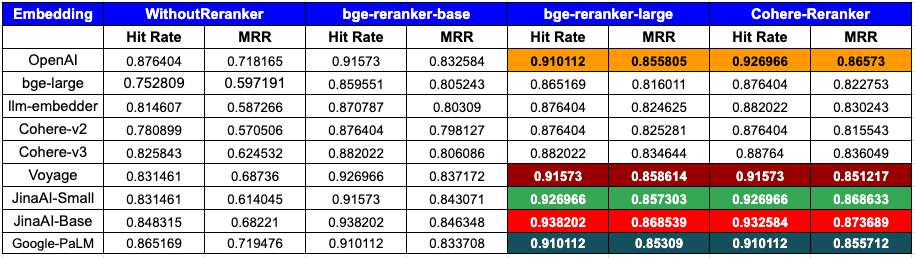

Please be aware that our benchmarks are intended to offer a reproducible script for your own data. Nevertheless, treat these figures as estimates and proceed with caution when interpreting them.